# The Garden of Forking Data (lecture 2)

> https://youtu.be/R1vcdhPBlXA



In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches


## Workflow

Steps:
- State a *clear scientific question* 
- Develop of a *causal model*
- Develop a *baysian estimator*.

## Scientific question: what proportion of Earth is covered by water?

Goal: we want to know what proportion of Earth is covered by water (the estimand). Instead of a point estimate, we want a probability distribution of the proportion of Earth covered by water.

Method: given a random sample of water vs land, we must use Bayesian inference to compute the posterior probability distribution of the proportion.

## Causal model

```
               ┌────┐                
          ┌───▶│ W  │◀───┐           
          │    └────┘    │           
┌────┐    │              │     ┌────┐
│ N  │────┤              ├─────│ p  │
└────┘    │              │     └────┘
          │    ┌────┐    │           
          └───▶│ L  │◀───┘           
               └────┘                
```

## Baysian estimator



###  Generative model

We model the sample-generating process as the random choice between two options of water (W) and land (L) with probabilities $p(W)$ and $p(L)$.

In [42]:
def sim_globe(p=0.7, n=9):
    return np.random.choice(['W', 'L'], p=[p, 1-p], size=n)

print(sim_globe(p=1))
print(sum(sim_globe(p=0.5, n=int(1e4)) == 'W') / 1e4)

['W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
0.4968


### Estimate posterior probability given sample

#### Approach 1: discretized globe

Sample: ['W' 'W' 'L' 'L' 'W' 'W' 'L' 'L' 'W']


,poss,ways,post
0,0.00,0.00,0.00
1,0.05,0.00,0.00
2,0.10,0.19,0.00
3,0.15,1.83,0.00
4,0.20,8.59,0.00
5,0.25,27.00,0.00
6,0.30,65.55,0.01
7,0.35,132.34,0.02
8,0.40,231.93,0.04
9,0.45,362.16,0.06


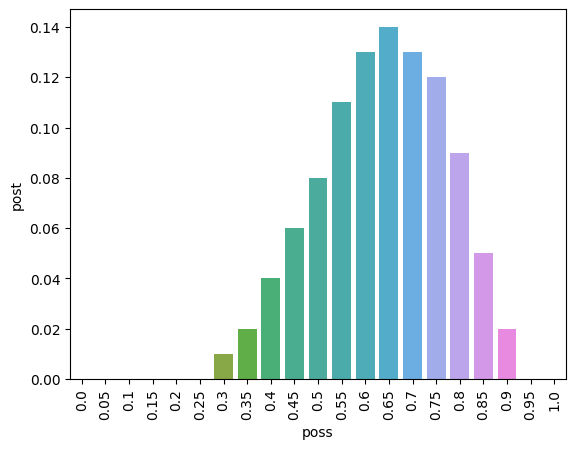

In [79]:
DEFAULT_POSS = np.linspace(0,1,21)
def compute_posterior(sample, world_size=4, poss=DEFAULT_POSS):
    W = sum(sample == 'W')
    L = sum(sample == 'L')
    f = lambda q: (world_size*q)**W * (world_size*(1-q))**L
    ways = np.array(list(map(f, poss, )))
    post = ways/ways.sum()
    return pd.DataFrame({'poss': poss, 'ways': ways, 'post': post}).round(2)

sample = sim_globe()
df = compute_posterior(sim_globe())
print('Sample:', sample)
display(df)
sns.barplot(df, x='poss', y='post')
plt.xticks(rotation=90)
plt.show()


#### Approach 2: smooth globe

The example for a spherical globe is almost exactly the same, since we don't care how many faces are on the surface, just what the proportion between water and land is.

The posterior destribution is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), with shape parameters W and L.

69 31


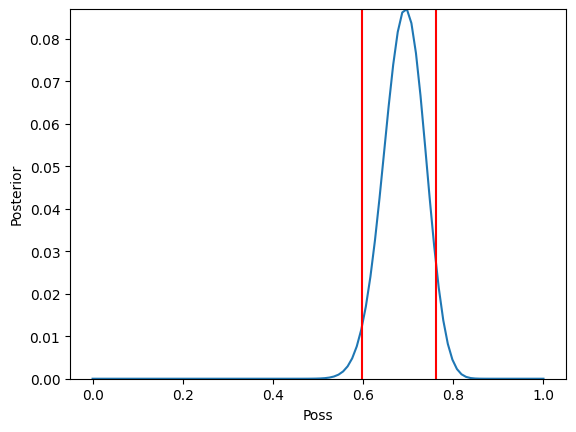

In [80]:
sample = sim_globe(p=0.7, n=100)
W = (sample == 'W').sum()
L = (sample == 'L').sum()
print(W,L)


X = np.linspace(0,1,100)
Y = stats.beta.pdf(X, W, L)
Y = Y/Y.sum()
sns.lineplot(x=X, y=Y)

# lower and upper bound for 95%
interval = 0.89
lower_p = (1-interval)/2
upper_p = 1-lower_p
lb = stats.beta.ppf(lower_p/2, W, L)
ub = LB = stats.beta.ppf(upper_p, W, L)
plt.axvline(lb, 0, 1, color='red')
plt.axvline(ub, 0, 1, color='red')
plt.ylim((0 ,Y.max()))
plt.xlabel('Poss')
plt.ylabel('Posterior')
plt.show()

### Estimate predictive posterior distribution

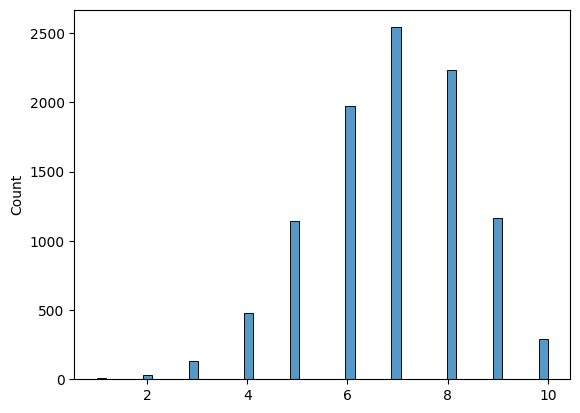

In [93]:
n_post_samples = int(1e4)
post_samples = np.random.beta(W, L, size=n_post_samples)
f_pred_post = lambda p: (sim_globe(p=p, n=10) == 'W').sum()
pred_post = np.fromiter(map(f_pred_post, post_samples), dtype=int)
pred_post
sns.histplot(pred_post)
plt.show()